# T022 - Ligand-based screening: Neural networks

Developed in the CADD seminar 2020, Volkamer Lab, Charité/FU Berlin 

Authors : 

- Ahmed Atta, CADD Seminar 2020, Charité/FU Berlin
- Sakshi Misra, [Volkamer lab](https://volkamerlab.org), Charité
- Talia B. Kimber, [Volkamer lab](https://volkamerlab.org), Charité
- Prof. Dr. Andrea Volkamer, [Volkamer lab](https://volkamerlab.org), Charité

## Aim of this talktorial

In recent years, the use of neural networks in pharmaceutical research has shown promising results in addressing diverse problems in drug discovery. In this talktorial, we get familiar with the basic structure of artificial neural networks and we will learn how to build a simple two layer neural network and use it to predict the pIC50 values of unknown compounds against our target of interest (EGFR). Furthermore, we will select three compounds from the unknown data set that are active against the EGFR kinase.

### Contents in *Theory*

- Biological background
    - EGFR
    - Compound activity measures
    - Molecule encoding
- What is a neural network ?
- Basic structure of a neural network
- What does a neuron do?
- Activation functions
    - Types of activation functions
- Loss function
- How to train a neural network
    - Backpropagation
    - Gradient descent
    - Workflow to train a neural network using keras
- Advantages and applications of neural network

### Contents in *Practical*

- Load data and visualize the dataframe
- Data preparation: molecule encoding
- Define keras model
- Choose the most appropriate batch sizes
- Fit keras model
- Prediction on test data
- Evaluate keras model
- Scatter plot between predicted and true pIC50 values
- Prediction on unknown data
- Select the top 3 compounds that are most active against the EGFR kinase

### References

 - Theoretical background:
 
     - Articles
     
         - Activation functions: Siddharth Sharma, "ACTIVATION FUNCTIONS IN NEURAL NETWORKS". [_International Journal of Engineering Applied Sciences and Technology, 2020_ **Vol. 4, Issue 12,** 310-316 (2020).](https://www.ijeast.com/papers/310-316,Tesma412,IJEAST.pdf)
         - Shun-ichi Amari, "Backpropagation and stochastic gradient descent method", [*ScienceDirect **Volume 5, Issue 4-5**, 185-196*]
         - Gisbert Schneider et al., "Artificial neural networks for computer-based molecular design", [*ScienceDirect **Volume 70, Issue 3**, 175-222*](https://doi.org/10.1016/S0079-6107(98)00026-1)
         - Filippo Amato et al., "Artificial neural networks in medical diagnosis", [*ScienceDirect **Volume 11, Issue 2**, 47-58*](https://doi.org/10.2478/v10136-012-0031-x)
          
     - Blogposts
     
          - Imad Dabbura, *Coding Neural Network — Forward Propagation and Backpropagtion*, [towards data science, accessed April 1st, 2018](https://towardsdatascience.com/coding-neural-network-forward-propagation-and-backpropagtion-ccf8cf369f76).
          - Lavanya Shukla, *Designing Your Neural Networks*, [towardsdatascience, accessed Sep 23rd, 2019](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)
          - Arthur Arnx, *First neural network for beginners explained (with code)*, [towardsdatascience, accessed Jan 13th, 2019](https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf) 
          - Varun Divakar, *Understanding Backpropagation*, [QuantInst, accessed Nov 19th, 2018](https://blog.quantinsti.com/backpropagation/) 
          - Aravind Pai, *CNN vs. RNN vs. ANN – Analyzing 3 Types of Neural Networks in Deep Learning*, [Analytics Vidya, accessed Feb 17th, 2020](https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf) 
     
     
- Packages:

     - [rdkit](): Greg Landrum, *RDKit Documentation*, [PDF](), Release on 2019.09.1.
     - [Keras](https://keras.io/): Book chapter: "An Introduction to Deep Learning and Keras" in [*Learn Keras for Deep Neural Networks* (2019), **page(s):1-16**](https://doi.org/10.1007/978-1-4842-4240-7).
     - [Sequential model](https://keras.io/api/models/sequential/) in keras
     - [Model training APIs](https://keras.io/api/models/model_training_apis/#model-training-apis)

## Theory

### Biological background

#### EGFR

- [Epidermal growth factor receptor (EGFR)](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor) is a transmembrane protein/receptor present on the cell membrane. It is a member of the ErbB family of receptors. They have an extracellular binding  component/domain, a hydrphobic transmembrane component/domain and an intracelluar tyrosine kinase component/domain. 

- EGFRs play an important role in controlling normal cell growth, apoptosis and other cellular functions. 

- It is activated by ligand binding to its extracellular domain, upon activation EGFR undergoes a transition from an inactive monomeric form to an active homodimers.

- The EGFR receptor is upregulated in various types of tumors or cancers, so an EGFR inhibition is a type of biological therapy that might stop cancer cell from growing.

#### Compound activity measures

- **IC50** is the half maximal inhibitory concentration of a drug which indicates how much a drug is needed to inhibit a biological process by half and in our case the epidermal growth factor receptor as its inhibition helps in slowing down or stopping cancer cell growth. 

- **pIC50** is the negative log of the IC50 value. It is more easily interpretable than IC50 values and a common measure for potency of compounds. (Please refer to [talktorial 001](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) for further details.)

#### Molecule encoding

For machine learning algorithms, molecules need to be converted into a list of features, in this case molecular fingerprints are used. 

Molecular fingerprints represent or encode the chemical structures and molecular features in bitstrings form, where at each position "1" represents the presence and "0" represents the absence of a feature.

One of the common fingerprints used are **M**olecular **ACC**ess **S**ystem fingerprints [(MACCS Keys)](https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#maccs) which are 166 bits structural key descriptors in which each bit is associated with a [SMARTS](https://docs.eyesopen.com/toolkits/python/oechemtk/glossary.html#term-smarts) pattern (Please refer to [talktorial 004](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T004_compound_similarity/talktorial.ipynb) for further details.)

### What is a neural network?

Neural networks, also known as artificial neural networks (ANNs) are a subset of machine learning algorithms. The structure and the name of the neural network is inspired by the human brain, mimicking the way that biological neurons transfers signal to one another.
ANNs are comprised of node layers, containing an input layer, one or more hidden layers, and an output layer. The operations of a complete neural network is straightforward: the input layer receives the input and the output layer predicts the final output. In between there exists hidden layers which performs the computations required by the network. We will discuss more about the structure in the next section.

<div>
<img src="images/neural_network.png" width="500" align="center"/>
</div>

*Figure 1:* Representation of a two-layer neural network. Figure is taken from the blogpost [Coding Neural Network — Forward Propagation and Backpropagtion](https://towardsdatascience.com/coding-neural-network-forward-propagation-and-backpropagtion-ccf8cf369f76)



### Basic structure of a neural network

Each node, or artificial neuron, connects to another via channels meaning a neuron of the column *n* can only be connected to neurons from column *n-1* and *n+1*. Every neural connection or channel has an associated numerical value known as weights. If the output of any individual neuron is above certain threshold value, that node is activated, meaning sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

Neural network consists of three main layers as shown below:

1. Input layer
2. Hidden layers 
3. Output layer 

<div>
<img src="images/basic_structure.png" width="500" align="center"/>
</div>

*Figure 2:* Figure shows the basic structure of a neural network. It is taken from the blogpost: "*Designing Your Neural Networks*", Lavanya Shukla, [towardsdatascience](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)

Lets take a deeper look at each layer,


- **Input neurons or input layer**

   - This layer represents the number of features which are used to make the predictions.
   - The input vector needs one input neuron per feature. For example as shown in the figure below, the image is composed of 28 * 28 = 784 pixels, each pixel will be fed as an input to each neuron of the first input layer.
   
 
<div>
<img src="images/input_vector.png" width="500" align="center"/>
</div>

*Figure 3:* Figure shows a hand written digit composed of 784 pixels which is given as an input to our first input layer neurons. It is taken from the blogpost: "*Designing Your Neural Networks*", Lavanya Shukla, [towardsdatascience](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)


- **Hidden layers and neurons per hidden layer**

    -  The optimal size of the hidden layer is usually between the size of the input and the size of the outputs layer. In general, using same number of neurons for all hidden layers will suffice but for some datasets, having a large first layer and following it up with smaller layers will lead to a better performance as first layers can learn a lot of low-level features that can fed into the next subsequent layers which can learn higher order features.
    - In the figure below, the input was a dog image broken into pixels, then several layers learn the different features and finally the network outputs it as a dog.

<div>
<img src="images/layer.png" width="500" align="center"/>
</div>

*Figure 4:* Figure shows the hidden layers learning certain features of a dog image. It taken from the blogpost: "*Designing Your Neural Networks*", Lavanya Shukla, [towardsdatascience](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)


- **Output neurons or output layer**

  - The output layer contains the number of neurons which represents the number of predictions you want to make and the neuron with highest value probability determines the output.
  - **Regression**: For regressions tasks, this can be a value like predicting the price of the house or predicting stock prices.
  - **Classification**: For binary classification tasks, we have an output neuron per positive class which represents the probability of the positive class whereas for multi-class classification, we have an output neuron per class and we use a certain activation function on the output layer to ensure the final probabilities sum to 1.

### What does a neuron do ?

Neurons are the basic units of a neural network, so lets understand the operations done by each neuron:

<div>
<img src="images/neuron.png" width="500" align="center"/>
</div>

*Figure 5:* Operations done by a neuron. Figure is taken from the blogpost: "*First neural network for beginners explained (with code)*", Arthur Arnx, [towardsdatascience](https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf)


- First, the values from the previous layer's neurons adds up and sent to the current neuron. In the figure above, there are 3 inputs $(x1, x2, x3)$ coming to the neuron, meaning 3 neurons are connected to our current neuron. 
- Each connection or channel has assigned a numerical value known as **weight** $(w1, w2, w3)$. Weight determines the connection between the neurons or in other words, a weight decides how much influence the input will have on the output. The inputs are multiplied by the corresponding weights and their sum is sent as input to the neurons in the hidden layer.
- Each of these neurons is associated with a numerical value called the **bias** which is then added to the input sum.
- Both weights and bias, commonly referred to as *w* and *b*, are the learnable parameters which can be tuned while training the model to get the better performance of a model. The equation below summarises the operations done by our neuron:


$$ Y = \sum (w1*x1 + w2*x2 + w3*x3) + bias $$

where, $Y$ = value of neuron after summation of weights and bias before activation function is applied

- After all those summations, the value is then passed through a threshold function called the **activation function**. The result of the activation function determines if the particular neuron will get activated or not. An activated neuron transmits data to the neuron of the next layer over the channels. In this manner the data is propagated through the network which is known as **forward propagation**. There are many types of activation functions which we will discuss in detail in the next section.

### Activation function

#### What is a activation function?

[Activation functions](https://en.wikipedia.org/wiki/Activation_function) are the mathematical equations that determine the output of a neural network. Each neuron is applied by this function and it determines whether the neuron should be activated or not. 

The value of **Y** can be anything ranging from $-\infty$ to $+\infty$ . The neuron doesn't know the bounds of the value, so how do we decide whether the neuron should be activated or not? Then, the activation functions comes into the picture which helps in normalizing the output of each neuron to a range between 1 and 0 or between -1 and 1 depending on the type of an activation function used. Activation function simply works as a "gate" in between the input feeding the current neuron and its output going to the next layer as shown below, 

<div>
<img src="images/activation.png" width="500" align="center"/>
</div>

*Figure 6:* Figure shows the activation function applied on a neuron. It is taken from the blogpost: [7 Types of Neural Network Activation Functions: How to Choose?](https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/)

#### Types of activation function

There are many types of activation but we will discuss the ones which we will use in the practical section below. For more information on some other types of activation functions, you can refer supplementary section and references.

Most neural networks uses non-linear activation functions as it makes easy for the model to generalize or adapt with variety of data and to differentiate between the output.

**Rectified Linear Unit (ReLU)** is one of the most commonly used activation function. 

- It takes the form: $$\boxed{f(x) = max\{ 0,x\}}$$

- As shown below in the figure, [ReLu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) gives an output $x$ if $x$ is positive and $0$ otherwise. The range of ReLu is [0, inf) which is not bound. 
- One of the reasons of it being commonly used could be its sparsity in the activation. Imagine if we have a deep neural network with many neurons, using a sigmoid or tanh will cause all the neurons to be activated, this is costly. But with ReLu, only few neurons will be activated and thereby making the activations sparse and efficient.
- The only issue is that when inputs approach to zero or negative, the gradient of the function becomes zero hence, the network cannot learn and perform backpropagation. 
- It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance

- We used ReLU activation function for both the hidden layers in while defining a keras model.

<div>
<img src="images/relu.png" width="400" align="center"/>
</div>

*Figure 7:* Representation of a "ReLU" function. Figure by Sakshi Misra


 
**Linear activation function** is an another type of activation function which we have used for the output layer. 

- A [linear](https://keras.io/api/layers/core_layers/dense/) activation function in keras takes the form: $$\boxed{a(x) = x}$$

- It is a straight line function where the activation is proportional to input which is the weighted sum from neuron. 
- The most appropriate activation function for the output neuron(s) of a neural network used for regression problems is a linear activation. Hence we used linear activation function on the output layer to predict the pIC50 values of the drugs.

### Loss function 

Before diving into how to train a neural network lets discuss about **loss** and **loss function**. In neural network, we have an objective function i.e. to minimize the prediction error, so this objective function is often referred to as cost function or loss function. Basically, through loss function we calculate loss or prediction error. Loss function is one of the important components of training the neural networks. 

Keras and tensorflow have various inbuilt loss functions, we will be covering some of them such as:

- **Mean Squared Error (MSE)**: It is used for regression tasks, as the name suggests this loss is calculated by taking the mean of squared differences between actual(target) and predicted values. 

- **Mean Absolute Error (MAE)**: It is also used for regression tasks, the loss is calculated by taking the mean of the absolute values of the individual prediction errors. (Prediction error is the difference between the actual values and the predicted values)

The choice of loss function is directly related to the activation function used in the output layer of your neural network. For example, in our case we have to predict the pIC50 value of drug molecules so it is a regression task. We can use linear activation function in the output layer and mean square error (mse) as our loss function.


You can refer to article: [Loss and Loss Functions for Training Deep Learning Neural Networks](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/) for more details.

### How to train a neural network ?

When we start with [forward propagation](https://en.wikipedia.org/wiki/Feedforward_neural_network), we randomly assign weights in our network. Obviously, it won’t give very good results, so how the network figures this out? 

During the training process along with the input our network also has the output fed to it. The predicted output is compared against the actual output to realize the error in prediction, the magnitude of the error indicates how wrong we are. This error is computed using loss function which we want to minimize and make it much lower at the end of training. It can be done by calculating the gradient by back propagating in the network and adjust the weights such that the network can predict the output correctly. 

There are major two algorithms which helps in training the neural network model:

- [Back propagation](https://de.wikipedia.org/wiki/Backpropagation): gradient computation  
- [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent#:~:text=Gradient%20descent%20is%20a%20first,the%20direction%20of%20steepest%20descent.): optimization method to minimize the loss or cost function

#### Backpropagation

Backpropagation is an efficient method of calculating the derivatives or gradient. This algorithm trains a neural network through a method called chain rule. In simple terms, after each forward pass through a network, backpropagation performs a backward pass while adjusting the model’s parameters (weights and biases) which aims to minimize the cost function.

#### Gradient descent 

**Gradient** is the vector which points to the direction of the steepest increase of the function. Since, we want to minimize our function, we will take a step in the opposite direction of gradient. Generally we want to control how big of step we make, this is achieved by choosing the most important hyper parameter which is called [learning rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b). Mostly people choose learning rate by trying out a bunch of numbers and using the one that looks to work best. 

In our neural network we have weights which values we want to improve, if we compute the gradient of the loss function w.r.t. to our weights and take small steps in the opposite direction of gradient, our loss will gradually decrease until it converges to some local minima, this algorithm is called **gradient descent**. So in short, it is the process of descending through the gradient i.e. adjusting the parameters of the model to minimize the loss function and achieve our target, which is to predict close to the original value. There many types of gradient descent method or say batch sizes which refers to the number of samples that will be propagated through the network to train it. Batches can made up of:

- **Stochastic Gradient Descent(SGD)**: When we train the model to optimize the loss function using only single sample from our dataset, it is called Stochastic Gradient Descent.
- **Batch Gradient Descent**: When we train the model to optimize the loss function using the the whole dataset, it is called Batch Gradient Descent.
- **Mini-Batch Gradient Descent**: Batch gradient descent takes a lot of time and is therefore somewhat inefficient. If we look at SGD, it is trained using only 1 example. There is a possibility that the model may get too biased with the peculiarity of that particular example when we use SGD. So, we use the mean of a batch of 10–1000 examples to check the optimize the loss in order to deal with the problems.


#### Workflow to train a neural network using keras

Let us first understand the basic workflow of how [keras](https://keras.io/getting_started/) helps in the process of deep learning. The goal is to train a neural network model with the training dataset and use test datasets to predict the pIC50 value for the drug molecules which it has never seen before.
 
- **Prepare data** − Foremost for any machine learning algorithm, we process, filter and select only the required information from the data. Then the data is split into training and test data set. Test data will be used to evaluate the prediction of the algorithm / model and to cross check the efficiency of the learning process.

 
- **Define the model** - In keras, every ANN is represented by keras [Models](https://keras.io/api/models/model/#model-class). keras provides a way to create a model which is called [sequential model](https://keras.io/api/models/sequential/). It is simple and easy to use. The layers are arranged sequentially where the data flows from one layer to another layer in the given order until the data finally reaches the output layer. Each layers in ANN can be represented by keras layer in keras. 


- **Compile the model** − The compilation is the final step in creating a model. Once the compilation is done, we can move on to training phase. This step requires us to choose **loss function** and **optimizer**. Loss function and optimizer are used in learning phase to find the error (deviation from actual output) and do optimization so that the error will be minimized. In this case we used **mean square error** as a loss argument and we defined optimizer to be **adam** which is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems. 

  To learn more about the Adam version of stochastic gradient descent see the post: [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).


- **Fit the model** - The actual learning process will be done in this phase using the training data set. We can call [fit()](https://keras.io/api/models/model_training_apis/#fit-method) method which needs several parameters like **X**: Input data, **y**: Target data, batch size, epochs etc. **Epochs** means number of times the model is needed to be evaluated during training process. For example **one epoch** means when an entire dataset is passed forward and backward through the neural network **once**.


- **Predict result for unknown value** − Keras provides a method, [predict](https://keras.io/api/models/model_training_apis/#predict-method) to get the prediction of the trained model.


- **Evaluate model** − We can evaluate the model by predicting the output for test data and cross-comparing the prediction with actual result of the test data by using [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method) method provided by keras. Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data. It has three main arguments,

   - Test data
   - Test data label
   - verbose - true or false

**Scatter plots** are a  common and simple approach to evaluate models which plots predicted vs. observed values (or vice versa) and compare slope and intercept parameters.

### Advantages and applications of neural network

#### Advantages of a neural network 

- **Organic learning**: Neural networks have the ability to learn by themselves by extracting the important features present in the input data. The outputs aren't limited entirely by inputs. Neural networks have the ability to generalize their inputs.
- **Non linear data processing**: They have the ability to learn and model non-linear and complex relationships. 
- **Fault tolerance**: They have potential for high fault tolerance. When these networks are scaled across multiple machines and multiple servers, they can debug and diagnose the problem by its own.

#### Applications of neural networks

There are various applications of neural networks in computer aided drug design  such as:

- Drug design and discovery
- Biomarker identification and/or classification
- Various types of cancer detection
- Pattern recognition etc.

Please refer to the article: "*Neural networks – advantages and applications*", [ScienceDirect](https://doi.org/10.1016/B978-0-444-81892-8.50036-5) for general applications.

## Practical

The first step is to import all the necessary libraries and define the functions and classes we intend to use in this notebook.

In [1]:
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint


# Silence some expected warnings
filterwarnings("ignore")

###  Load data and visualize the dataframe

Let's load our data which is the subset of ChEMBL dataset and visualize the dataframe, the important columns in the dataframe are:

- CHEMBL-ID
- SMILES string of the corresponding compound
- Measured affinity: pIC50

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

df = pd.read_csv(DATA/'CHEMBL25_activities_EGFR.csv',
                 index_col = 0)  # NBVAL_CHECK_OUTPUT

df=df.reset_index(drop=True)

In [3]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

# Look at head
df.head()

Shape of dataframe :  (3906, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         3906 non-null   object 
 1   IC50              3906 non-null   float64
 2   units             3906 non-null   object 
 3   canonical_smiles  3906 non-null   object 
 4   pIC50             3906 non-null   float64
dtypes: float64(2), object(3)
memory usage: 152.7+ KB


,chembl_id,IC50,units,canonical_smiles,pIC50
0,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


In [4]:
# Keep the necessary columns
chembl_df = df[["chembl_id", "canonical_smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,chembl_id,canonical_smiles,pIC50
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


### Data Preparation

#### Molecule encoding
Now we have to convert the SMILES string to numerical data so that we can perform machine learning algorithm on it and we can use already defined function `smiles_to_fp` from Talktorial **T007** which generate fingerprints from SMILES. 
There is a choice incorporated between **MACCS**, **morgan2** and **morgan3** but we will use MACCS fingerprints because MACCS keys are short (166 bit) as compared to others (2048 bit). (Please refer to [talktorial 007](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T007_compound_activity_machine_learning/talktorial.ipynb) for further details on the functions defined for molecule encoding. )

In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}."
              " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [6]:
# convert all SMILES strings to MACC fingerprints
chembl_df['fingerprints_df'] = chembl_df['canonical_smiles'].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head(3)  # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3906, 4)


,chembl_id,canonical_smiles,pIC50,fingerprints_df
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Now we can define **features** and the **target data** which will be used to train the model. In our case, features are the bit vectors and the target value is pIC50 values of the drug molecules which we want to predict.

We can then use `train_test_split` from scikit-learn library to split the data into training and testing datasets.

In [8]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
             chembl_df['fingerprints_df'], 
             chembl_df[['pIC50']], test_size=0.3, random_state=42)

# Print the shape of training and testing data
print("Shape of training data : ", X_train.shape)
print("Shape of testing data : ", X_test.shape)

Shape of training data :  (2734,)
Shape of testing data :  (1172,)


### Define keras model

We defined the model by specifying the number of neurons or nodes in the layer as the first argument and activation function using the activation argument. We have used [rectified linear unit activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) in the hidden layers and [linear](https://keras.io/api/layers/core_layers/dense/) in the output layer to predict the pIC50 values.

After defining, we compiled the model by we using **mean square error** as a loss argument and **adam** as an optimizer.

In [9]:
def NN_model(hidden1, hidden2):
    """
    creating neural network from two hidden layer
    using relu as activation function in two hidden layer
    and linear in the output layer

    parameters
    ----------
    hidden1 : Int
         number of neuons in first hidden layer

    hidden2: Int
         number of neuons in second hidden layer
    Returns
    --------
    model
        fully connected neural network model with two hidden layer
    """

    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden1, activation='relu', name="layer1"))
    # second hidden layer
    model.add(Dense(hidden2, activation='relu', name="layer2"))
    # output layer
    model.add(Dense(1, activation='linear', name="layer3"))
    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['mse', 'mae'])
    return model

### Choose the most appropriate batch sizes 

We have passed different mini-batches and plotted the loss.

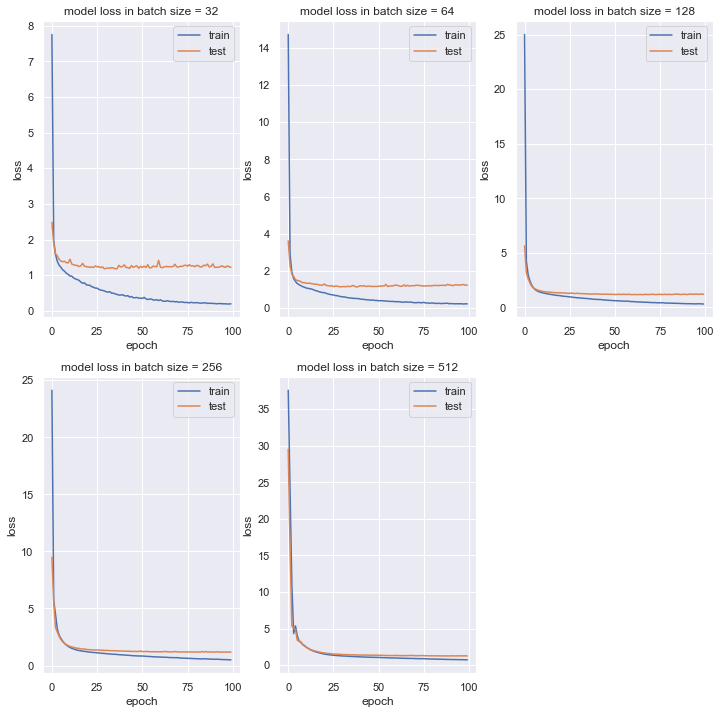

In [10]:
# trying different batch sizes
batch_sizes = [32, 64, 128, 256, 512]

# size of figure
fig = plt.figure(figsize=(12, 12))
sns.set(color_codes=True)
for index in range(len(batch_sizes)):
    fig.add_subplot(2, 3, index+1)
    model = NN_model(64, 32)
  # fit model on X_train and y_train data
    history = model.fit(np.array(list((X_train))).astype(float), y_train.values,
                        batch_size=batch_sizes[index],
                        validation_data=(np.array(list((X_test))).astype(float), y_test.values),
                        verbose=0, epochs=100)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f"model loss in batch size = {str(batch_sizes[index])}")
plt.show()

### Fit keras model

Now we can train the model by passing several arguments like features, target data, epochs and batch size. We specified batch size to be 512 because from the figure above, it has the lowest loss and epochs to be 100. 

[ModelCheckpoint callback](https://keras.io/api/callbacks/) is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [11]:
# save the model
filepath = "weights_CV.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0,
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit the model
model.fit(np.array(list((X_train))).astype(float), y_train.values, 
          epochs=100, batch_size=512,
          callbacks=callbacks_list, verbose=0)

### Evaluate keras model

We can use [evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) method to check the performance or score of our model. It will report the loss, mse and mae values.

In [13]:
# Evalute the model 
print(f"Evaluate on test data")
score = model.evaluate(np.array(list((X_test))), y_test, verbose=0)
print(f'score:{score}')  # NBVAL_CHECK_OUTPUT

Evaluate on test data
score:[1.23137629032135, 1.23137629032135, 0.8475707173347473]


### Predict keras model on test data

Prediction is the final step and our expected outcome of the model generation. Keras provides a method, [predict()](https://keras.io/api/models/model_training_apis/#predict-method) to get the prediction of the trained model. We can use  this method to predict the pIC50 values on test data. 

In [24]:
# Predict pIC50 values on X_test data 
y_pred = model.predict(np.array(list((X_test))))
y_pred

array([[4.581886 ],
       [6.5868163],
       [7.0754876],
       ...,
       [5.0091805],
       [7.5914598],
       [4.364357 ]], dtype=float32)

### Scatter plot between predicted and true pIC50 values

[Scatter_plots](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.scatter.html) are used to plot the predicted vs true values. We can see that there is a positive linear relation between the points with some outliers.

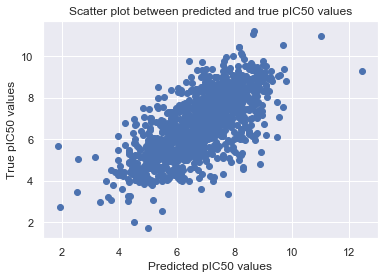

In [14]:
# Scatter plot 
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted pIC50 values')
plt.ylabel('True pIC50 values')
plt.title('Scatter plot between predicted and true pIC50 values')
plt.show()  # NBVAL_CHECK_OUTPUT

Now we can use our trained model and predict pC50 values on unknown data.

### Prediction on unknown data

We will use another dataset to test the model. This dataset contains some SMILES compounds without the pIC50 values, we can load the dataset using pandas and visualize the dataframe.

In [15]:
test_df = pd.read_csv(DATA/'test.csv',
                      index_col = 0)
test_df.head()  # NBVAL_CHECK_OUTPUT

,canonical_smiles
id,
1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1
2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1
3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1
4,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...
5,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...


We used the same `smiles_to_fp` function and convert the SMILES strings in test data as well into MACCS fingerprints.

In [16]:
# convert all SMILES strings to MACC fingerprints
test_df['fingerprints_df'] = test_df['canonical_smiles'].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", test_df.shape)
test_df.head(3)  # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (60, 2)


,canonical_smiles,fingerprints_df
id,,
1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
# prediction on test data
pred = model.predict(np.array(list((test_df['fingerprints_df']))).astype(float), callbacks=None)

predicted_pIC50 = pd.DataFrame(pred, columns=['Predicted pIC50 values'])
predicted_pIC50_df = test_df.join(predicted_pIC50)

predicted_pIC50_df.head(3)  # NBVAL_CHECK_OUTPUT

,canonical_smiles,fingerprints_df,Predicted pIC50 values
id,,,
1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.314307
2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.107604
3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.222931


### Select the top 3 compounds that are most active against the EGFR kinase

Now we can select 3 drugs that can be used as epidermal growth factor receptor inhibitor with highest pIC50 values.

In [18]:
# select top 3 drugs
top3_drug = predicted_pIC50_df.nlargest(3, 'Predicted pIC50 values')
top3_drug

,canonical_smiles,fingerprints_df,Predicted pIC50 values
id,,,
53,C[NH2+][C@@]1(CC/C(=N/C)/C=C1)[C@]2(c3ccc(cc3C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.489796
9,O(CC)c1c(OCC)cc2ncnc(C#Cc3c(-c4ccccc4)cc[nH]3)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.341873
18,O(C)c1cc([O-])c2C(=O)C=3[C@H](O)[C@@H](O)[C@](...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.337502


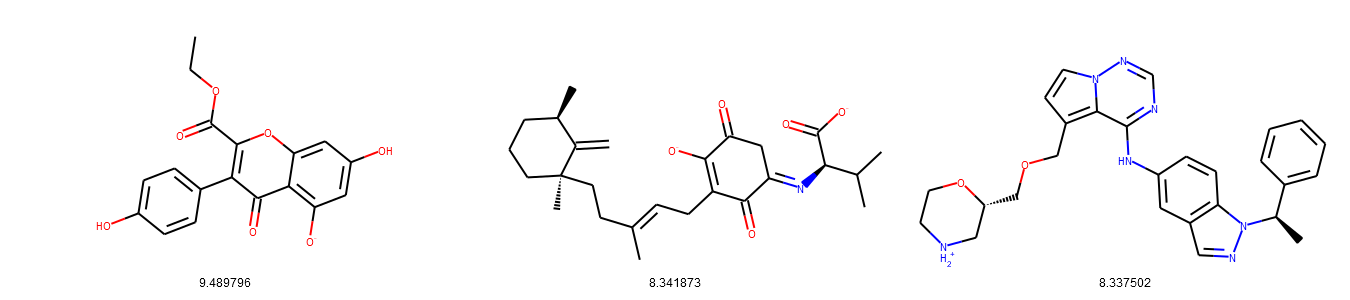

In [19]:
# draw the drug molecules
highest_pic50 = predicted_pIC50_df['canonical_smiles'][[17, 8, 15]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pic50]
pic50_EGFR = top3_drug['Predicted pIC50 values'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pic50_EGFR)

## Discussion





From above we can see that there are some groups which are common in all the 3 drugs such as ..

This predictive modelling is advantageous because it is not time consuming as compared to laboratory experiments and it is also cheap comparatively. It also gives the general overview about the possible drugs can be used as EGFR inhibitor drugs. 

Also this model has some disadvantages like it depends upon the parameters and variables used and these parameters can be tuned differently which might results in different drug molecules having different pIC50 values. This also does not provide the information about the side effect of the compounds and their toxicity on normal cells.

In general , this Neural network model for prediction of pic50 of molecules form their bit vectors is good to provide an overview about the possible drugs that can be used in experiments. Therefore , we can reduce the number of experiments and work on selected drug molecules.

## Quiz

- What other hyperparameters can be tuned to get better performance result?
- What other activation functions and metrices can be used while defining the model?
- Can you think of any other visualization method to visualize the prediction and observed values?

-------
## Supplementary section

In this section we have defined other activation functions and forward propagation function for better understanding of the concept.

Lets discuss some other activation functions and define them using python.

1) **Sigmoid function (σ)**: It takes the form: $$\boxed{f(x)=\frac{1}{1+e^{−x}}}$$ 

   -  The sigmoid curve looks like a *S*-shaped curve as shown in the figure below. 
   - It has a "smooth gradient" which prevents jumps in the output values and it bound the output values between 0 and 1.
   - It's recommended to be used only on the output layer so that we can easily interpret the output as probabilities since it has restricted output between 0 and 1. 
   - If you notice in the figure below, x values between -2.5 to 2.5, Y values are very steep, so any small change in values of x in that region will cause value of y to change significantly. It tends to bring the activations to either side of the curve.
   - Another advantage of this activation function, unlike linear function, the output of the activation function is always going to be in range (0,1) compared to (-inf, inf) of linear function.
   - But it has a major drawback, for very high or very low values of X, there is almost no change in y values or the prediction, causing a [**vanishing gradient**](https://towardsdatascience.com/the-vanishing-exploding-gradient-problem-in-deep-neural-networks-191358470c11) problem. This can cause the network to learn slowly or refuses to learn further. 
     
<div>
<img src="images/sigmoid.png" width="400" align="center"/>
</div>

*Figure 9:* Representation of a "sigmoid" function. Figure by Sakshi Misra.

2) **Hyperbolic Tangent function or TanH**:  It takes the form: $$\boxed{f(x)= tanh(x) = \frac{2}{1+e^{-2x}}−1}$$ it looks very similar to sigmoid function, it can also be written as $$\boxed{tanh(x)= \text{2 sigmoid (2x)}-1}$$

   - It has same characteristics as sigmoid like non-linear in nature, output is bound between -1 and 1 but it has deeper [derivatives](https://en.wikipedia.org/wiki/Derivative) which means it has stronger gradient than sigmoid as shown in the figure below. Deciding between sigmoid and tanh depends upon your requirement of gradient strength.
   - The disadvantage that it shares with sigmoid function is that the it also has vanishing gradient problem.

<div>
<img src="images/tanh.png" width="400" align="center"/>
</div>

*Figure 10:* Representation of a "tanh" function. Figure by Sakshi Misra

3) **Leaky Rectified Linear Unit**: ReLu takes the form: $$\boxed{f(x)= \max\{ α ∗ x,x\}}$$

   - This is the variation of ReLU which has a small positive slope in the negative area.
   - The range of the Leaky ReLU is (-infinity to infinity).
   - It overcomes the zero gradient issue from ReLU and assigns α which is a small value for x≤0.

<div>
<img src="images/leaky.png" width="400" align="center"/>
</div>

*Figure 12:* Representation of a "Leaky ReLU" function. Figure by Sakshi Misra


Now which activation function do we choose? It totally depends on the type of the problem you are solving, you can choose an activation function which will approximate the function faster and lead to faster raining process. There are other activation functions too, but the general idea remains the same. Please refer an article: H. N. Mhaskar, [How to Choose an Activation Function](https://papers.nips.cc/paper/1993/file/51ef186e18dc00c2d31982567235c559-Paper.pdf) for more details.

Now we define the above discussed activation functions in python and plot them.

In [20]:
# Define activation functions that can be used in forward propagation
def sigmoid(input_array):
    """
    Computes the sigmoid of input element-wise.

    Parameters
    ----------
    input_array : array
             input values.

    Returns
    -------
    Activation_function : array
             post activation output.
    input_array : array
             input values.
    """
    Activation_function = 1 / (1 + np.exp(-input_array))

    return Activation_function, input_array


def tanh(x):
    """
    Computes the Hyperbolic Tagent of input element-wise.

    Parameters
    ----------
    input_array : array
             input values.

    Returns
    -------
    Activation_function : array
             post activation output.
    input_array : array
             input values.
    """
    Activation_function = np.tanh(input_array)

    return Activation_function, input_array


def relu(input_array):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Parameters
    ----------
    input_array : array
             input values.
    Returns
    -------
    Activation_function : array
             post activation output.
    input_array : array
             input values.
    """
    Activation_function = np.maximum(0, input_array)

    return Activation_function, input_array


def leaky_relu(input_array):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Parameters
    ----------
    input_array : array
             input values.

    Returns
    -------
    Activation_function : array
             post activation output.
    input_array : array
             input values.
    """
    Activation_function = np.maximum(0.1 * input_array, input_array)

    return Activation_function, input_array

We can also plot all the activation function using `matplotlib.plt` library as shown below.

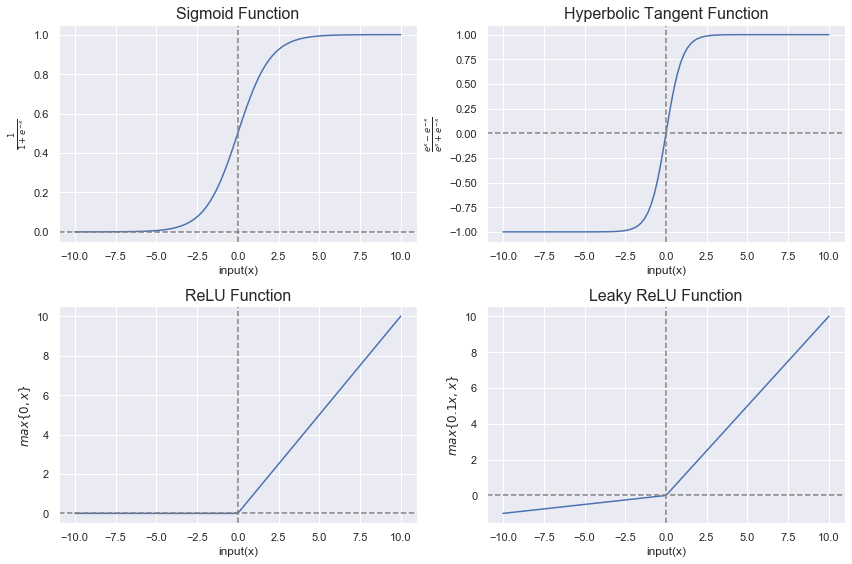

In [21]:
# Plot the 4 activation functions
input_array = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, input_array = sigmoid(input_array)
A_tanh, input_array = tanh(input_array)
A_relu, input_array = relu(input_array)
A_leaky_relu, input_array = leaky_relu(input_array)

# Plot sigmoid function
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(input_array, A_sigmoid, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$\frac{1}{1 + e^{-x}}$")
plt.title("Sigmoid Function", fontsize=16)

# Plot tanh function
plt.subplot(2, 2, 2)
plt.plot(input_array, A_tanh, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$\frac{e^x - e^{-x}}{e^x + e^{-x}}$")
plt.title("Hyperbolic Tangent Function", fontsize=16)

# plot relu function
plt.subplot(2, 2, 3)
plt.plot(input_array, A_relu, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$max\{0, x\}$")
plt.title("ReLU Function", fontsize=16)

# plot leaky relu function
plt.subplot(2, 2, 4)
plt.plot(input_array, A_leaky_relu, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$max\{0.1x, x\}$")
plt.title("Leaky ReLU Function", fontsize=16)
plt.tight_layout()

Now, we will define forward propagation function using classes, this implementation might help you to understand the forward propagation concept better.

First we converted our input bit vectors data into lists and then defined a class named `Layer_Dense`. It has two properties, weights and biases. We have randomly assigned their values and defined a function named `forward_pass` which calculates the **dot product** of the input values and weights and add it to the bias values. 

Now, as we know activation function is applied on every neuron, so we have created another class named `activation_function`, here we have defined the a function named `ReLU`, meaning we will use ReLU activation function in this case. 

After defining classes and their attributes, we create an object from both the classes and called the functions on our data. We can now print the output values as shown.

**Note:** The predicted values will differ in every run because the weights are randomly assigned.  

In [22]:
# convert our input data to list
fingerprints_df_list = chembl_df.values.tolist()


# create forward pass function with one hidden layer
class Layer_Dense:
    """
    A class to represent a neural network
    
    '''
    Attributes
    ----------
    n_inputs : int
        number of neurons in input layer
    n_neurons : int
        number of neurons in hidden layer

    Method
    ------
    forward_pass(inputs):
        computes the forward pass of a neural network.
    """

    def __init__(self, n_inputs, n_neurons):
        """
        Constructs all the necessary attributes.

        Parameters
        ----------
        n_inputs : int
            number of neurons in input layer
        n_neurons : int
            number of neurons in hidden layer

        """
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward_pass(self, inputs):
        """
        Computes forward pass.

        Parameters
        ----------
        input : int
            input neurons.

        Returns
        -------
        None
        
        """
        self.output = np.dot(inputs, self.weights) + self.biases


class Activation_function:
    """
    A class to represent an activation function

    Method
    ------
    ReLU(inputs):
        computes the ReLU activtaion function.
    """
    def ReLU(self, inputs):
        """
        Computes activation function applied on neuron.

        Parameters
        ----------
        input : int
            input neurons.

        Returns
        -------
        None
        
        """
        self.output = np.maximum(0, inputs)


        
# object
layer1 = Layer_Dense(167, 50)
layer2 = Layer_Dense(50, 1)
activation1 = Activation_function()
activation2 = Activation_function()

# function calling
layer1.forward_pass(fingerprints_df_list)
layer2.forward_pass(layer1.output)
activation1.ReLU(layer1.output)
activation2.ReLU(layer2.output)

print(activation2.output)

ValueError: setting an array element with a sequence